**Dynamic Asset Allocation Across Economic Cycles**

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [116]:
from google.colab import files
uploaded = files.upload()

Saving Yield_data.csv to Yield_data (1).csv


In [125]:
import io
from datetime import datetime
df = pd.read_csv(io.BytesIO(uploaded['Yield_data.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date'] #set dates as index for timeseries
del df['Date']
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')
TS = pd.DataFrame.copy(df)
df.tail()

# Dataset is now stored in a Pandas Dataframe

,10Y,1Y,2Y,30Y,3M,3Y,5Y,6M
Date,,,,,,,,
2019-10-14,1.753,1.657,1.614,2.214,1.682,1.586,1.577,1.681
2019-10-15,1.769,1.646,1.622,2.230,1.671,1.603,1.597,1.665
2019-10-16,1.745,1.594,1.585,2.232,1.669,1.565,1.566,1.632
2019-10-17,1.755,1.594,1.600,2.243,1.669,1.579,1.577,1.630
2019-10-18,1.750,1.578,1.576,2.248,1.671,1.555,1.559,1.624


In [126]:
col_list = []
for col in df.columns: 
    col_list.append(col)
print(col_list)

['10Y', '1Y', '2Y', '30Y', '3M', '3Y', '5Y', '6M']


In [127]:
# Standardize the Data
from sklearn.preprocessing import StandardScaler

features = col_list

# create standardized df

df = StandardScaler().fit_transform(df)

print(df)


[[ 0.35351813  0.10686381  0.20269525 ...  0.24279084  0.26861807
   0.07379501]
 [ 0.34738661  0.10946988  0.19741986 ...  0.23467233  0.26294358
   0.06539915]
 [ 0.3228605   0.09122743  0.18950676 ...  0.22655382  0.25443183
   0.05980192]
 ...
 [-1.3679078  -0.88239786 -0.97239925 ... -1.05211228 -1.19369969
  -0.82679988]
 [-1.36484204 -0.88239786 -0.96844271 ... -1.04832364 -1.19057872
  -0.8273596 ]
 [-1.36637492 -0.88656756 -0.97477318 ... -1.05481845 -1.19568576
  -0.82903877]]


In [128]:
# PCA on macroeconomic data FRED-MD
pca = PCA(n_components = 2)
principalcomponents = pca.fit_transform(df)

pcadf = pd.DataFrame(data = principalcomponents, columns = ['Principal component 1', 'Principal component 2'])

pcadf.head(3)

,Principal component 1,Principal component 2
0,0.585170,-0.337766
1,0.569664,-0.332175
2,0.542847,-0.329328


In [129]:
# Explained Variance from pca model
pca.explained_variance_ratio_

array([0.9774815 , 0.02033594])

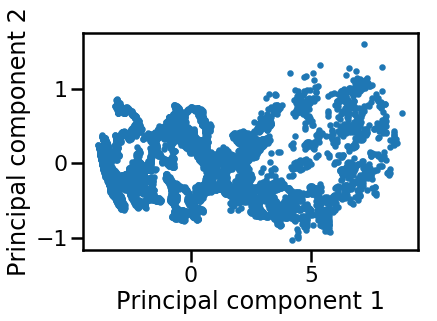

In [130]:
#Visualize PCA data
pcadf.plot.scatter(x='Principal component 1', y = 'Principal component 2')

In [131]:
#Clustering
import statsmodels.tsa.stattools as ts
import seaborn as sns
import sklearn.cluster as cluster
import time
!pip install hdbscan
import hdbscan
from sklearn.cluster import KMeans
import pylab as pl

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels, palette

(array([2, 2, 2, ..., 0, 0, 0], dtype=int32),
 [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
  (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
  (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
  (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
  (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
  (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)])

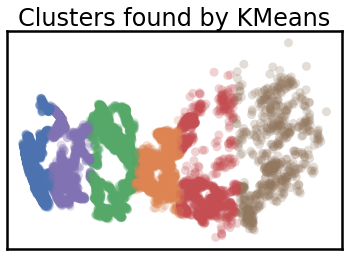

In [132]:
data = principalcomponents.copy()
plot_clusters(principalcomponents, cluster.KMeans, (), {'n_clusters':6})

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


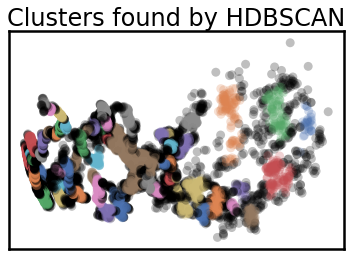

In [138]:
#@title Minimum business days per cluster
cluster_size = 21 #@param {type:"slider", min:0, max:100, step:1}

TS.is_copy = False
TS['clusters'], colors = plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':cluster_size})     
cluster_labels = set(TS['clusters'])

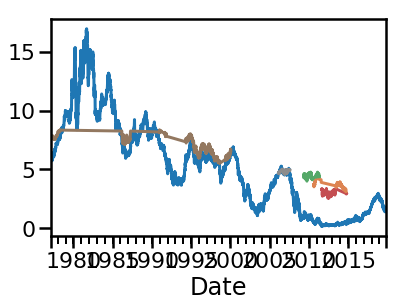

In [139]:
fig,ax=plt.subplots()
TS[['2Y']].plot(ax = ax, style ='-')

cluster_freq = np.unique(TS['clusters'], return_counts=True)
df_cf_t = pd.DataFrame([cluster_freq[0],cluster_freq[1]])
df_cf = (df_cf_t.transpose()).sort_values([1],ascending = False) 
i = 0
#for cluster_label in cluster_labels:
for i in range(0,top_clusters):
    cluster_label = df_cf.iloc[i][0]
    if (cluster_label >= 0):
        TS[['30Y']][TS['clusters'] == cluster_label].plot(ax = ax, color = colors[cluster_label])
 
        ax.legend_.remove()